# Modersmærkekræft recognition

In [18]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"

## Iteration 1

In [12]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model1.keras',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback]  # Add both callbacks
)

Epoch 1/100


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6235 - loss: 10.7966
Epoch 1: val_loss improved from inf to 4.83319, saving model to models/best_model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - accuracy: 0.6237 - loss: 10.7883 - val_accuracy: 0.7358 - val_loss: 4.8332
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7547 - loss: 4.9483
Epoch 2: val_loss improved from 4.83319 to 3.98370, saving model to models/best_model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7548 - loss: 4.9469 - val_accuracy: 0.6995 - val_loss: 3.9837
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8218 - loss: 2.7497
Epoch 3: val_loss did not improve from 3.98370
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8218 - loss: 2.7506 - val_accuracy: 0.7409 - val_loss: 5.4454
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8429 - loss: 2.2100
Epoch 4: val_loss improved from 3.98370 to 2.95293, saving model to mode

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━

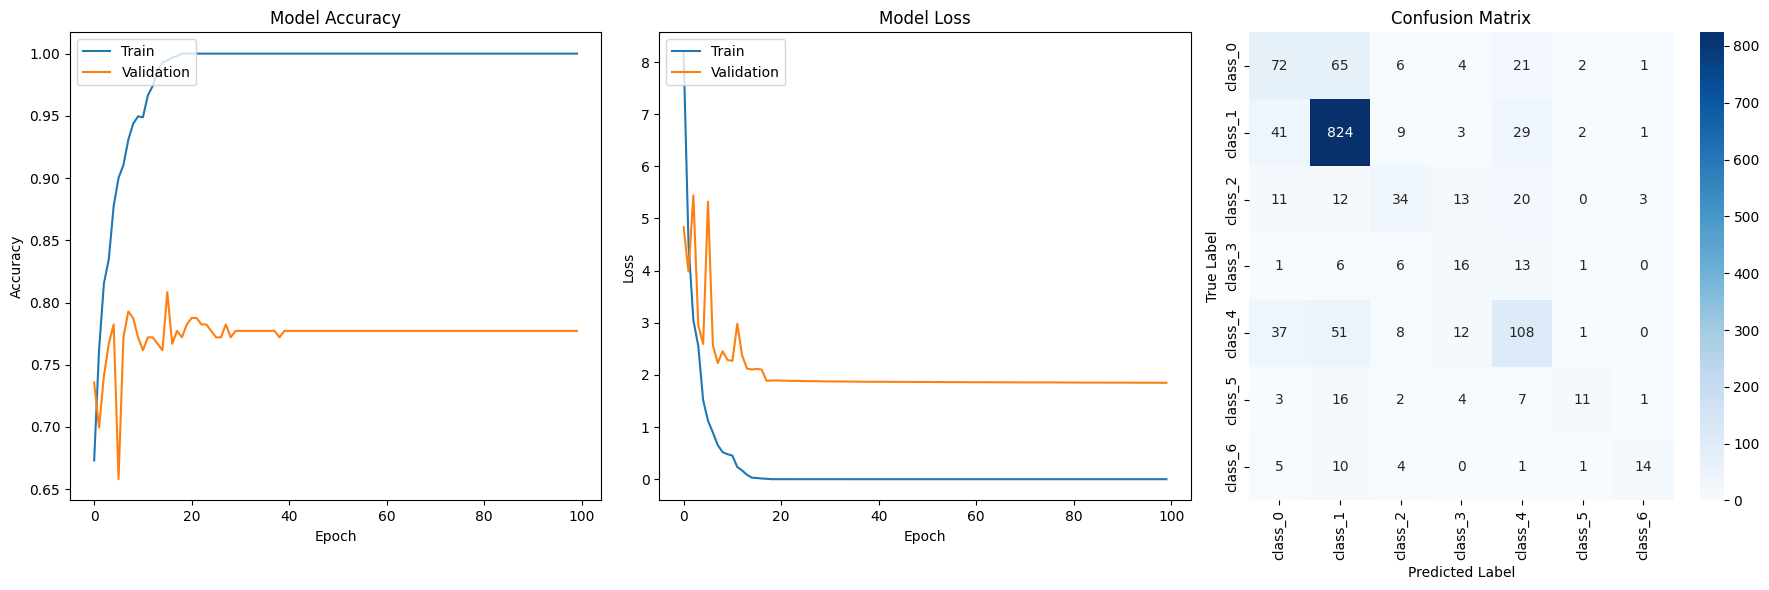

In [16]:
show_all_plots(history2, model, test_generator)

In [17]:
results = model.evaluate(test_generator)

 1/48 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6875 - loss: 2.5457

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7042 - loss: 4.7873


### What did we learn????

- Overfitting:
    - No
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We do not overfit, so we can try with a more complex model?
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

## Iteration 2

This is a script to test what learning rate we should use (and scheduler)

In [31]:

from keras.optimizers import SGD
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
import matplotlib.pyplot as plt

batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)






# Custom callback to record the learning rate at each epoch
class LearningRateTracker(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() if hasattr(self.model.optimizer, 'learning_rate') else self.model.optimizer.lr.numpy()
        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)

# To store learning rates per decay strategy
learning_rates_dict = {}



total_number_of_images = len(train_generator)



initial_lr = 0.01
decay_rate = initial_lr * 0.01
# Learning rate decay functions
def linear_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr - decay_rate * epoch

initial_lr = 0.01
decay_rate = 0.1
def inverse_sqrt_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr / np.sqrt(1 + decay_rate * epoch)

initial_lr = 0.01
drop = 0.5
epochs_drop = 1/5 * epochs
def step_decay(epoch, initial_lr=initial_lr, drop=drop, epochs_drop=epochs_drop):
    return initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))


fraction = 0.1
total_number_trainingsteps = (total_number_of_images / batch_size) * epochs
decay_steps = total_number_trainingsteps * fraction
initial_learning_rate = 0
warmup_steps = total_number_trainingsteps * fraction
target_learning_rate = 0.1
cosine_with_warmup_decay = optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.5
inverse_time_decay = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate)


starter_learning_rate = 0.1
end_learning_rate = starter_learning_rate * 0.1 
decay_steps = total_number_trainingsteps * 0.75
power = 0.3

print("decay steps", decay_steps)

polynomial_decay = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=starter_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power
)


initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.96
exponential_decay = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


sgd_configs = {}
#sgd_configs.update({f'cosine_with_warmup_decay': SGD(learning_rate=cosine_with_warmup_decay)})
sgd_configs.update({f'inverse_time_decay': SGD(learning_rate=inverse_time_decay)})
sgd_configs.update({f'polynomial_decay': SGD(learning_rate=polynomial_decay)})
sgd_configs.update({f'exponential_decay': SGD(learning_rate=exponential_decay)})
sgd_configs.update({f'constant': SGD(learning_rate=0.001)})



config_callbacks = {
    'linear_decay': {
        'callback': LearningRateScheduler(lambda epoch: linear_decay(epoch)),
    },
    'inverse_sqrt_decay': {
        'callback': LearningRateScheduler(lambda epoch: inverse_sqrt_decay(epoch)),
    },
    'step_decay': {
        'callback': LearningRateScheduler(lambda epoch: step_decay(epoch)),
    },
}

results = {}

for key in sgd_configs:

  sgd = sgd_configs[key]

  lr_tracker = LearningRateTracker()

  # Compile model - make it trainable
  model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

  # Train the model
  history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      callbacks=[lr_tracker]
  )

  learning_rates_dict[key] = lr_tracker.learning_rates
  # Evaluate the model on the validation set
  val_loss, val_acc = model.evaluate(validation_generator)
  results[key] = history
  print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')

for key in config_callbacks:
    sgd = SGD()
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)

    sgd = SGD()

    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
    lr_tracker = LearningRateTracker()
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[config_callbacks[key]['callback'], lr_tracker])

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[f"{key}"] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')


# Plotting learning rate decay over time for each configuration
plt.figure(figsize=(12, 8))
for key, lrs in learning_rates_dict.items():
    plt.plot(range(len(lrs)), lrs, label=f'{key} LR decay')

plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Comparison')
plt.legend()
plt.show()

for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.
decay steps 366.796875
Epoch 1/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 39/313 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.5502 - loss: 95.9641

KeyboardInterrupt: 

In [30]:
learning_rates_dict

{'inverse_time_decay': [0.1,
  0.00063492067,
  0.00031847134,
  0.00021253986,
  0.00015948963,
  0.00012763242,
  0.00010638298,
  9.119927e-05,
  7.980846e-05,
  7.094714e-05,
  6.385696e-05,
  5.8055153e-05,
  5.32198e-05,
  4.912798e-05,
  4.562044e-05,
  4.258037e-05,
  3.992016e-05,
  3.7572798e-05,
  3.5486162e-05,
  3.3619097e-05,
  3.1938678e-05,
  3.0418252e-05,
  2.9036006e-05,
  2.777392e-05,
  2.6616983e-05,
  2.5552576e-05,
  2.4570025e-05,
  2.366024e-05,
  2.2815424e-05,
  2.2028858e-05,
  2.129472e-05,
  2.0607935e-05,
  1.9964065e-05,
  1.935921e-05,
  1.878993e-05,
  1.8253171e-05,
  1.774623e-05,
  1.7266684e-05,
  1.6812373e-05,
  1.6381358e-05,
  1.597189e-05,
  1.5582393e-05,
  1.5211439e-05,
  1.4857737e-05,
  1.452011e-05,
  1.4197487e-05,
  1.3888889e-05,
  1.3593421e-05,
  1.3310262e-05,
  1.303866e-05],
 'polynomial_decay': [0.1,
  0.038914107,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.00

inverse_time_decay: val_acc: 0.7461140155792236, val_loss: 2.193234443664551


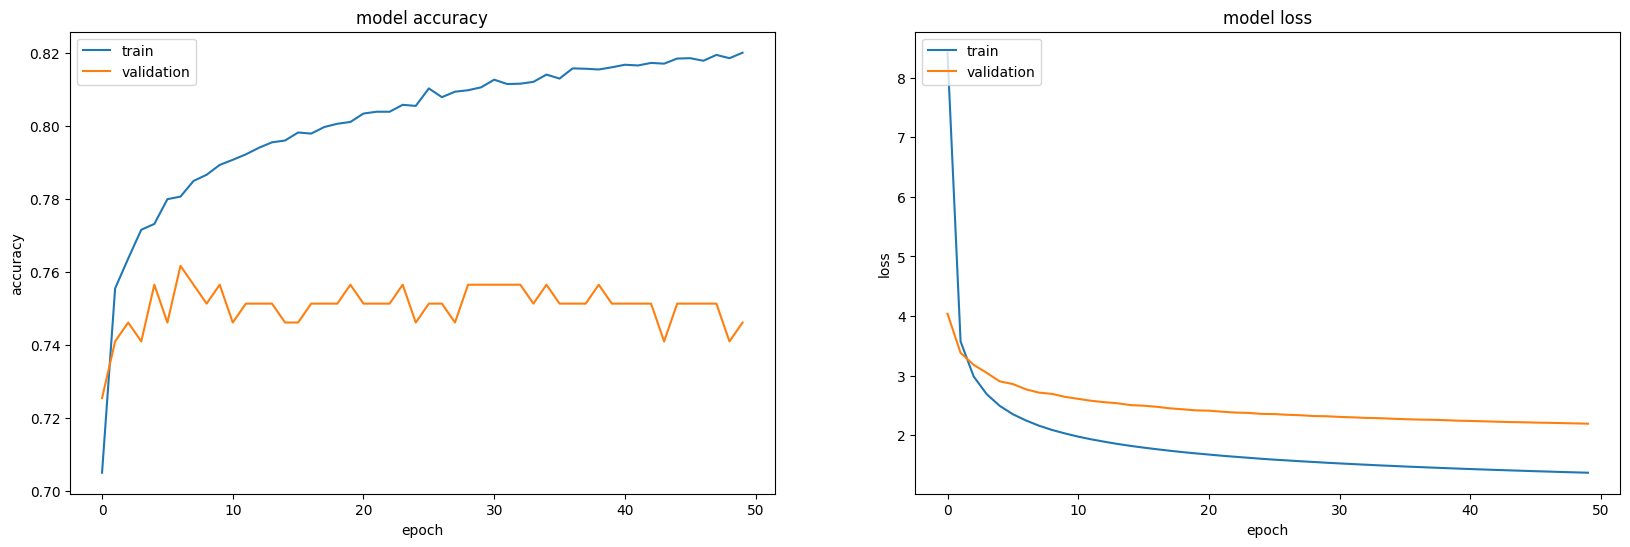

polynomial_decay: val_acc: 0.7823834419250488, val_loss: 7.800882339477539


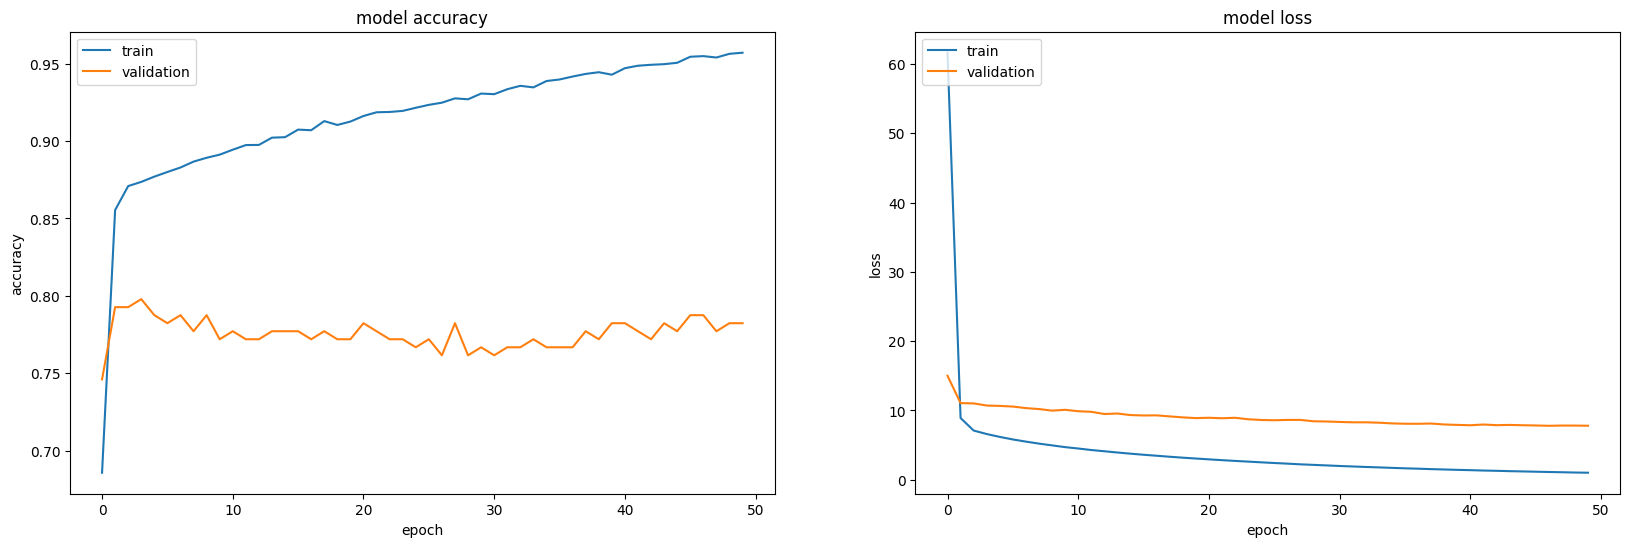

exponential_decay: val_acc: 0.7772020697593689, val_loss: 12.202298164367676


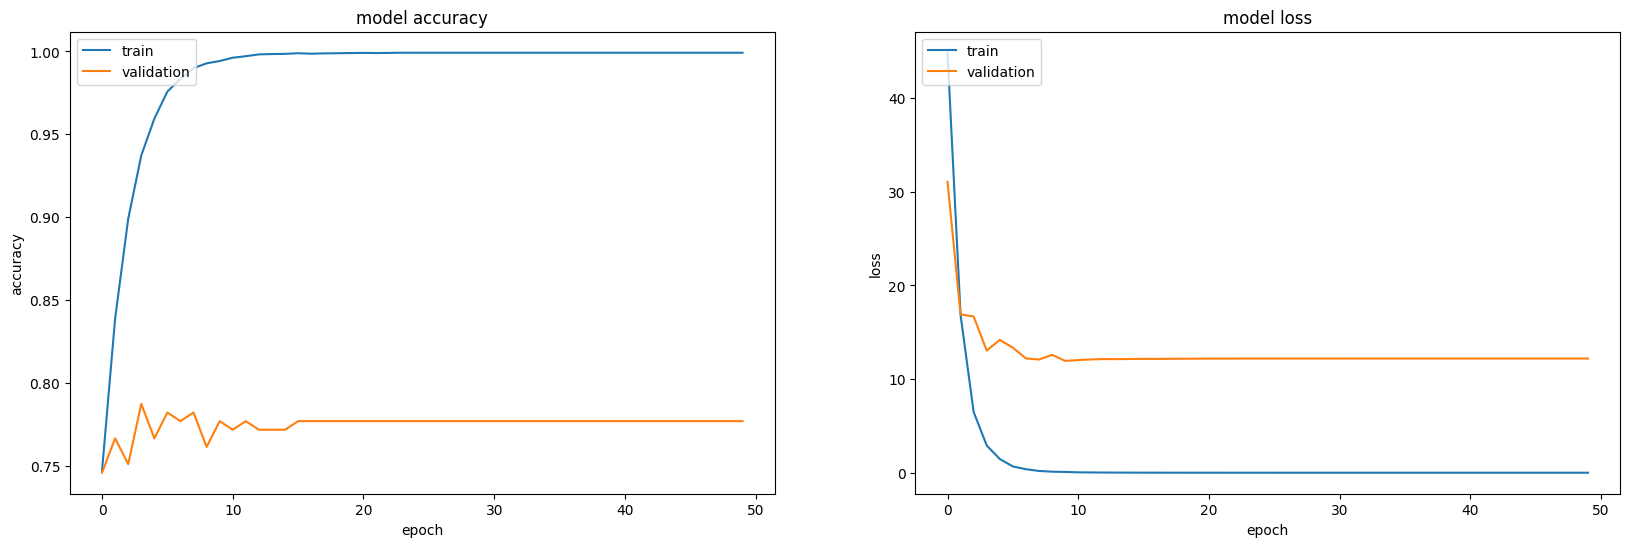

constant: val_acc: 0.7668393850326538, val_loss: 12.27414321899414


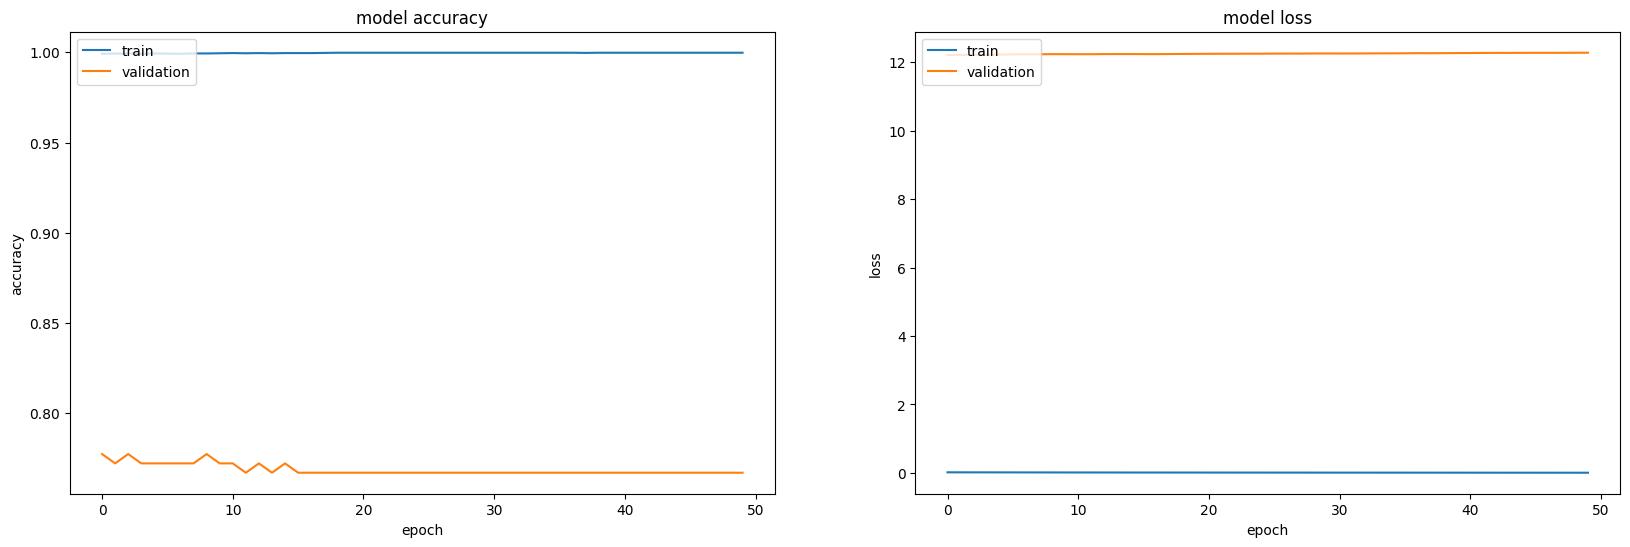

linear_decay: val_acc: 0.7772020697593689, val_loss: 12.182926177978516


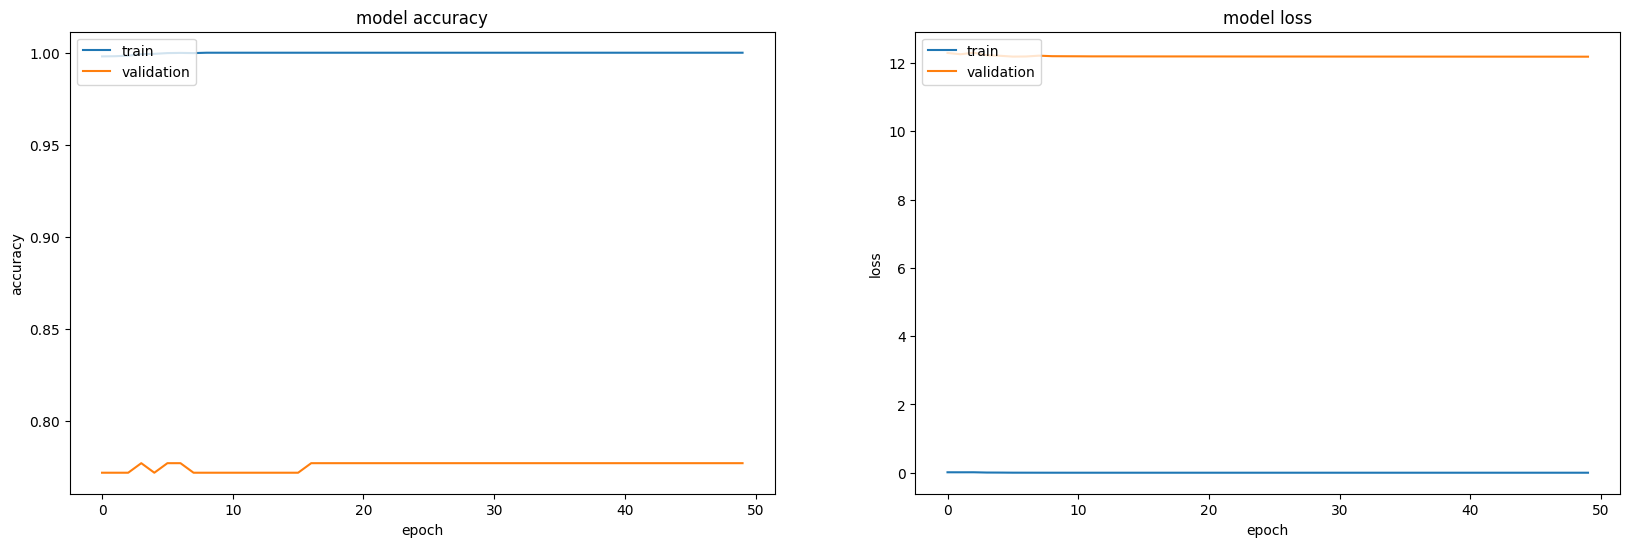

inverse_sqrt_decay: val_acc: 0.7772020697593689, val_loss: 12.175792694091797


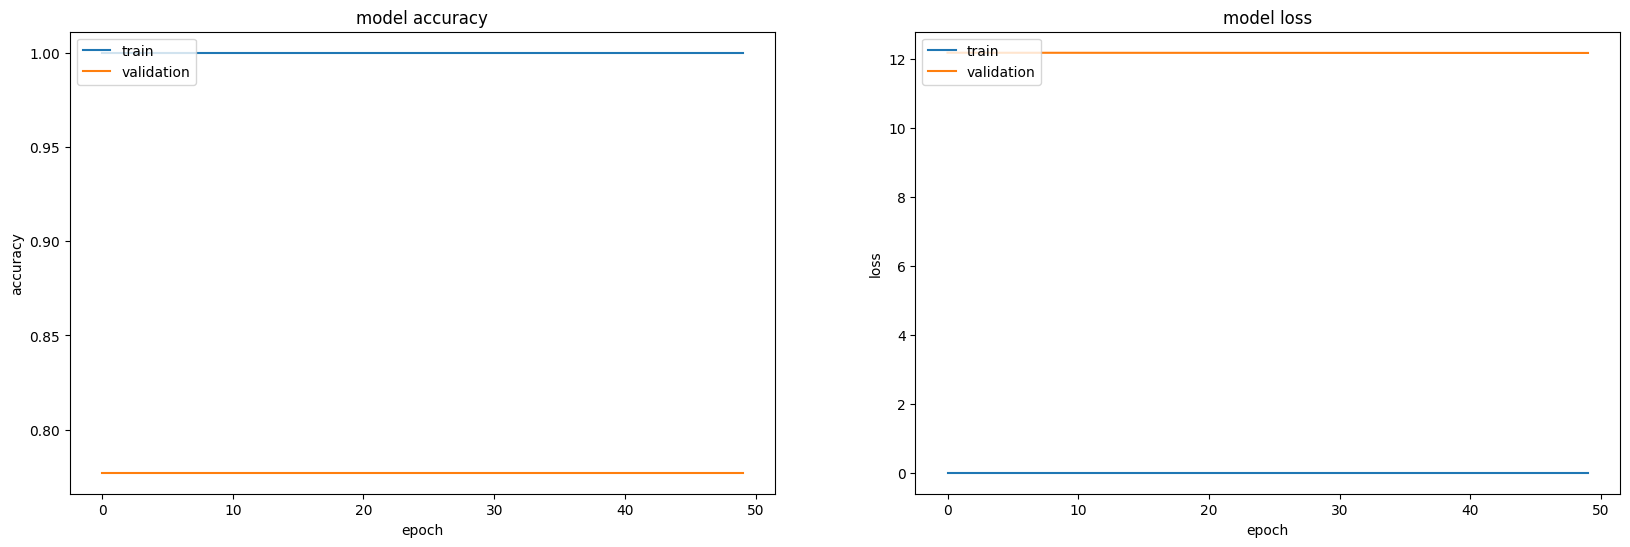

step_decay: val_acc: 0.7772020697593689, val_loss: 12.172455787658691


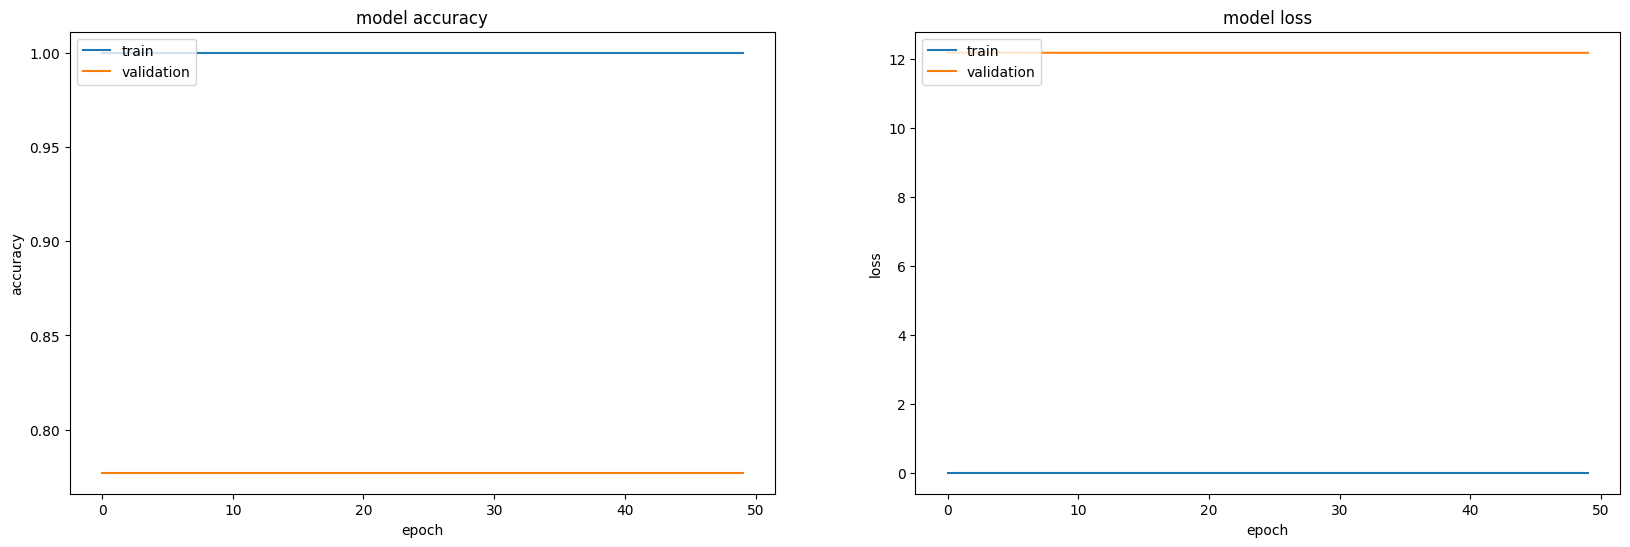

In [29]:
for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")
    show_history(history)

# Utils

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


""" def show_all_plots(history, model, X_val, y_val):

    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

    # Get predictions for confusion matrix
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Set up a 1x3 grid for the plots
    plt.figure(figsize=(18, 6))

    # 1. Accuracy plot
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 2. Loss plot
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show all the plots
    plt.tight_layout()
    plt.show() """


def show_history(history):

  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def show_confusion_matrix(model, X_val, y_val):

    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

    y_pred = model.predict(X_val)

    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_val, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # 5. Visualize the confusion matrix using seaborn
    plt.figure(figsize=(2,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_comparison_of_models(res):
    # Set up a 1x3 grid for the plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot accuracy
    for model_name, history in res.items():
        print(model_name)
        if history is not None:
            axs[0].plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
            axs[0].plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')

    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(loc='upper left')
    axs[0].grid()

    # Plot loss
    for model_name, history in res.items():
        if history is not None:
            axs[1].plot(history.history['loss'], label=f'{model_name} Train Loss')
            axs[1].plot(history.history['val_loss'], label=f'{model_name} Val Loss')

    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend(loc='upper left')
    axs[1].grid()

    # Plot final accuracy bar chart
    final_accuracies = {model_name: history.history['val_accuracy'][-1] if history is not None else 0 for model_name, history in res.items()}

    axs[2].bar(final_accuracies.keys(), final_accuracies.values(), color='royalblue')
    axs[2].set_title('Final Validation Accuracy for Each Model')
    axs[2].set_ylabel('Final Accuracy')
    axs[2].set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
    axs[2].grid(axis='y')

    plt.tight_layout()  # Adjusts subplot params for better fit
    plt.show()




def show_all_plots(history, model, validation_generator):
    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_indices.keys())

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))
        y_true.extend(np.argmax(y_val_batch, axis=1))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Set up a 1x3 grid for the plots
    plt.figure(figsize=(18, 6))

    # 1. Accuracy plot
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 2. Loss plot
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show all the plots
    plt.tight_layout()
    plt.show()





